#Environment Setup & Project Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# If running for the first time, uncomment to clone nanoGPT:
# !git clone https://github.com/karpathy/nanoGPT.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/nanoGPT"

/content/drive/MyDrive/nanoGPT


# Preparing a Manageable Training Subset

In [ ]:
# ============================================================
# Preparing a 120M-token subset of the original dataset
# ============================================================

import os
import shutil
import numpy as np

# NOTE FOR THE USER:
# Before running this script, ensure that your full dataset files
# (train.bin, val.bin, test.bin, meta.pkl, vocab.json)
# are placed inside the folder: data/my_music/
# This directory should contain the original full dataset so that
# a smaller subset (e.g., 120M tokens) can be created for nanoGPT.

SRC_DIR = "/content/drive/MyDrive/data/my_music"
DST_DIR = "/content/drive/MyDrive/data/my_music_subset"

SRC_TRAIN = os.path.join(SRC_DIR, "train.bin")
DST_TRAIN = os.path.join(DST_DIR, "train.bin")

# Create subset directory if not exists
os.makedirs(DST_DIR, exist_ok=True)

# ------------------------------------------------------------
# Copy all small files (meta.pkl, vocab.json, test.bin, val.bin)
# ------------------------------------------------------------
for fname in ["meta.pkl", "vocab.json", "test.bin", "val.bin"]:
    src = os.path.join(SRC_DIR, fname)
    dst = os.path.join(DST_DIR, fname)
    print(f"Copying {fname} → subset folder...")
    shutil.copy(src, dst)

# ------------------------------------------------------------
# Subset the 1B-token train.bin
# ------------------------------------------------------------
N = 120_000_000   # 120M tokens

print("\nLoading original train.bin...")
data = np.memmap(SRC_TRAIN, dtype=np.uint16, mode='r')

print(f"Original train token count: {len(data):,}")
print(f"Creating subset of first {N:,} tokens...")

subset = data[:N]

print(f"Writing new train.bin to {DST_TRAIN}...")
subset_mm = np.memmap(DST_TRAIN, dtype=np.uint16, mode='w+', shape=(N,))
subset_mm[:] = subset[:]
subset_mm.flush()
del subset_mm  # ensure write is completed

print("Subset dataset is ready in:", DST_DIR)

Model Configuration Files

Inside the nanoGPT/config directory, I maintain five custom configuration scripts—each corresponding to a different model size used in the scaling experiments. These are:

	•	music_char_1M.py – 1M parameters
	•	music_char_5M.py – 5M parameters
	•	music_char_20M.py – 20M parameters
	•	music_char_50M.py – 50M parameters
	•	music_char_100M.py – 100M parameters

Each configuration file specifies the embedding dimension, number of layers, heads, dropout, block size, and other hyperparameters required to build a model of the target parameter budget. These configs were used throughout the project to train and compare models under a controlled scaling setup.

# Training All Model Sizes (1M–100M Parameters)

Train the 1M-Parameter Model

In [ ]:
!python train.py config/music_char_1M.py

Train the 5M-Parameter Model

In [ ]:
!python train.py config/music_char_5M.py

Train the 20M-Parameter Model

In [ ]:
!python train.py config/music_char_20M.py

Train the 50M-Parameter Model

In [ ]:
!python train.py config/music_char_50M.py

Train the 100M-Parameter Model

In [ ]:
!python train.py config/music_char_100M.py

# Evaluating Training Checkpoints & Plotting Validation Loss Curves

This section loads every checkpoint saved during training (e.g., ckpt_*.pt files), restores the model from each checkpoint, computes its validation loss using a fixed number of random samples from val.bin, and plots validation loss vs. training iterations.
This allows us to visualize how model performance evolves across training and compare convergence behavior for different parameter scales.

In [3]:
import os, glob, math, torch, pickle, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import GPT


def evaluate_checkpoints_transformer(
    out_dir,
    data_dir="../data/my_music_subset",
    num_samples=200,
    device="cuda",
    verbose=True
):
    """
    Evaluate all checkpoints inside OUT_DIR, compute validation loss,
    and generate a plot of val loss vs iteration.

    Args:
        out_dir (str): Directory containing ckpt_*.pt files.
        data_dir (str): Directory with val.bin and meta.pkl.
        num_samples (int): Samples used for validation loss estimation.
        device (str): "cpu" or "cuda".
        verbose (bool): Print per-ckpt logs.
    """

    # ------------------------
    # Load metadata + validation data
    # ------------------------
    meta_path = os.path.join(data_dir, "meta.pkl")
    val_path  = os.path.join(data_dir, "val.bin")

    with open(meta_path, "rb") as f:
        meta = pickle.load(f)

    itos = meta["itos"]
    vocab_size = len(itos)
    if verbose:
        print("vocab_size:", vocab_size)

    val = np.memmap(val_path, dtype=np.uint16, mode='r')
    if verbose:
        print(f"Validation tokens: {len(val):,}")

    # ------------------------
    # Load model from checkpoint
    # ------------------------
    def load_model_from_ckpt(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)

        state_dict = ckpt["model"]
        cfg = ckpt.get("model_args", {})

        # Build minimal config object
        class C: pass
        C.vocab_size = vocab_size
        C.block_size = cfg.get("block_size", 512)
        C.n_layer    = cfg.get("n_layer", 4)
        C.n_head     = cfg.get("n_head", 4)
        C.n_embd     = cfg.get("n_embd", 144)
        C.dropout    = cfg.get("dropout", 0.1)
        C.bias       = cfg.get("bias", True)

        model = GPT(C)
        model.load_state_dict(state_dict, strict=True)
        model.to(device)
        model.eval()

        if verbose:
            n_params = sum(p.numel() for p in model.parameters())/1e6
            print(f"Loaded model: {n_params:.2f}M params")

        return model, C.block_size

    # ------------------------
    # Compute validation loss
    # ------------------------
    @torch.no_grad()
    def compute_val_loss(model, block_size):
        total = 0.0
        for _ in range(num_samples):
            i = np.random.randint(0, len(val) - block_size - 1)

            chunk = val[i:i+block_size+1].astype(np.int64)
            x = torch.tensor(chunk[:-1]).unsqueeze(0).to(device)
            y = torch.tensor(chunk[1:]).unsqueeze(0).to(device)

            logits, loss = model(x, y)
            total += loss.item()

        return total / num_samples

    # ------------------------
    # Sort checkpoints by iteration
    # ------------------------
    def extract_iter(path):
        m = re.search(r"ckpt_(\d+)\.pt", path)
        return int(m.group(1)) if m else -1

    ckpt_paths = sorted(
        glob.glob(os.path.join(out_dir, "ckpt_*.pt")),
        key=extract_iter
    )

    if verbose:
        print("Found checkpoints:", ckpt_paths)

    # ------------------------
    # Evaluate all checkpoints
    # ------------------------
    results = []

    for ck in ckpt_paths:
        it = extract_iter(ck)

        if verbose:
            print(f"\nEvaluating checkpoint @ iter {it}")

        model, bs = load_model_from_ckpt(ck)
        val_loss = compute_val_loss(model, block_size=bs)
        ppl = math.exp(val_loss)

        if verbose:
            print(f"iter {it}: val_loss={val_loss:.4f}, perp={ppl:.2f}")

        results.append((it, val_loss, ppl))
        del model
        torch.cuda.empty_cache()

    if not results:
        print("No checkpoints found.")
        return None

    # ------------------------
    # Plot
    # ------------------------
    iters = [r[0] for r in results]
    losses = [r[1] for r in results]

    plt.figure(figsize=(12,5))
    plt.plot(iters, losses, marker='o')
    plt.xticks(iters, rotation=70)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss Across Training Iterations\n({out_dir})")
    plt.tight_layout()
    plt.show()

    # ------------------------
    # Token estimate
    # ------------------------
    tokens_per_iter = 32 * 512  # your setup
    last_iter = max(iters)
    total_tokens = tokens_per_iter * last_iter

    print(f"\nEstimated tokens processed: {total_tokens/1e6:.2f}M")

    return results

In [ ]:
evaluate_checkpoints_transformer("out-music-char-1M")
evaluate_checkpoints_transformer("out-music-char-5M")
evaluate_checkpoints_transformer("out-music-char-20M")
evaluate_checkpoints_transformer("out-music-char-50M")
evaluate_checkpoints_transformer("out-music-char-100M")

# Scaling Law Fit — Model Size vs Validation Loss

This section fits a power-law scaling curve to your models’ performance.
Provide the parameter counts of each trained model and the corresponding validation loss (taken from your checkpoint evaluation plots).


===== Fitted Power Law Parameters =====
a     = 14857.88951241499
alpha = 0.8199893070998961
c     = 0.3617364121785521


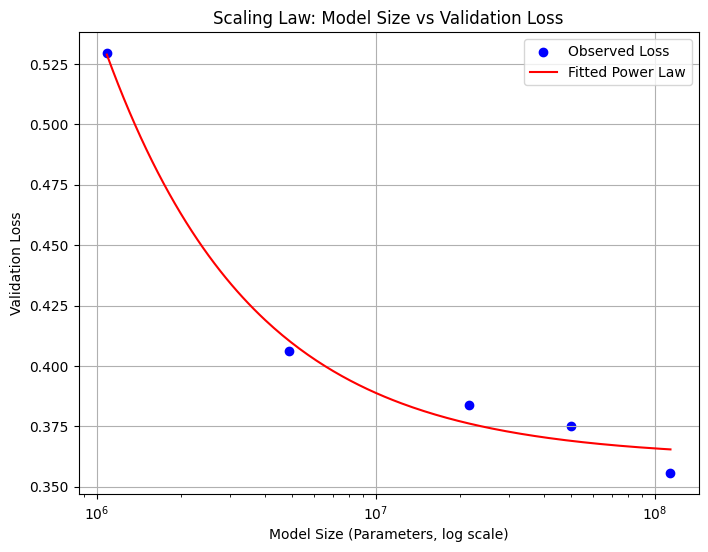

In [5]:
# ============================================
# Scaling Law Fit: Model Size vs Validation Loss
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --------------------------------------------------------
# Model sizes (in parameters) — already filled for you
# --------------------------------------------------------
model_sizes = np.array([
    1_084_464,     # ~1M model
    4_878_080,     # ~5M model
    21_477_504,    # ~20M model
    50_160_516,    # ~50M model
    113_740_032    # ~100M model
], dtype=float)

# --------------------------------------------------------
# Validation losses — FILL THESE WITH YOUR VALUES
# (from your evaluation plots for each model)
# --------------------------------------------------------
val_losses = np.array([
    # Replace with your observed values:
    0.5295, 0.4060, 0.3837, 0.3751, 0.3556
], dtype=float)

if len(val_losses) != len(model_sizes):
    raise ValueError("val_losses must contain exactly 5 values (one per model).")

# --------------------------------------------------------
# Power-law function: L = a * N^(-alpha) + c
# --------------------------------------------------------
def power_law(N, a, alpha, c):
    return a * (N ** -alpha) + c

# Fit curve
popt, pcov = curve_fit(power_law, model_sizes, val_losses,
                       p0=[1.0, 0.1, 0.1])  # initial parameter guess

a, alpha, c = popt
print("\n===== Fitted Power Law Parameters =====")
print(f"a     = {a}")
print(f"alpha = {alpha}")
print(f"c     = {c}")

# --------------------------------------------------------
# Plot results
# --------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(model_sizes, val_losses, color='blue', label="Observed Loss")

# Smooth x-range for curve visualization
Ns = np.logspace(np.log10(min(model_sizes)), np.log10(max(model_sizes)), 200)
plt.plot(Ns, power_law(Ns, *popt), color='red', label="Fitted Power Law")

plt.xscale("log")
plt.xlabel("Model Size (Parameters, log scale)")
plt.ylabel("Validation Loss")
plt.title("Scaling Law: Model Size vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

# Training LSTM-Based RNN Models (1M–50M Parameters)

With the dataset prepared, we train a family of character-level LSTM models at four different parameter scales (1M, 5M, 20M, and 50M).
Each model has a dedicated configuration file inside RNN/config/

In [ ]:
%cd "/content/drive/MyDrive/RNN"

Initiate training using the following functions:

In [ ]:
!python train_lstm.py config/rnn_char_1M.py
!python train_lstm.py config/rnn_char_5M.py
!python train_lstm.py config/rnn_char_20M.py
!python train_lstm.py config/rnn_char_50M.py

# RNN Model Evaluation: Validation Loss vs. Training Iterations

In [ ]:
import os, glob, math, torch, pickle, re
import numpy as np
import matplotlib.pyplot as plt
from char_rnn_model import CharRNN   # <-- you will create this import

def evaluate_rnn_checkpoints(
    out_dir,
    data_dir="../data/my_music_subset",
    num_samples=200,
    device="cuda",
    verbose=True
):

    # ------------------------
    # Load metadata + validation data
    # ------------------------
    meta = pickle.load(open(os.path.join(data_dir, "meta.pkl"), "rb"))
    vocab_size = len(meta["itos"])
    if verbose: print("vocab_size:", vocab_size)

    val = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode='r')
    if verbose: print(f"Validation tokens: {len(val):,}")

    # ------------------------
    # Function: load RNN from checkpoint
    # ------------------------
    def load_model_from_ckpt(path):
        ckpt = torch.load(path, map_location=device, weights_only=False)
        cfg  = ckpt["model_args"]

        model = CharRNN(
            vocab_size=vocab_size,
            n_embd=cfg["n_embd"],
            n_layer=cfg["n_layer"],
            dropout=cfg["dropout"]
        ).to(device)

        model.load_state_dict(ckpt["model"], strict=True)
        model.eval()

        if verbose:
            n_params = sum(p.numel() for p in model.parameters()) / 1e6
            print(f"Loaded RNN model: {n_params:.2f}M params")

        return model, cfg["block_size"]

    # ------------------------
    # Validation loss
    # ------------------------
    @torch.no_grad()
    def compute_val_loss(model, block_size):
        total = 0.0
        for _ in range(num_samples):
            i = np.random.randint(0, len(val) - block_size - 1)
            chunk = val[i:i+block_size+1].astype(np.int64)

            x = torch.tensor(chunk[:-1]).unsqueeze(0).to(device)
            y = torch.tensor(chunk[1:]).unsqueeze(0).to(device)

            _, loss = model(x, y)
            total += loss.item()

        return total / num_samples

    # ------------------------
    # Sort ckpts by iteration
    # ------------------------
    def extract_iter(path):
        m = re.search(r"ckpt_(\d+)\.pt", path)
        return int(m.group(1)) if m else -1

    ckpts = sorted(
        glob.glob(os.path.join(out_dir, "ckpt_*.pt")),
        key=extract_iter
    )

    if verbose:
        print("Found checkpoints:", ckpts)

    if not ckpts:
        print("No checkpoints found.")
        return None

    # ------------------------
    # Evaluate
    # ------------------------
    results = []
    for ck in ckpts:
        it = extract_iter(ck)
        print(f"\nEvaluating checkpoint @ iter {it}")

        model, block_size = load_model_from_ckpt(ck)
        val_loss = compute_val_loss(model, block_size)
        ppl = math.exp(val_loss)

        print(f"iter {it}: val_loss={val_loss:.4f}, perp={ppl:.2f}")

        results.append((it, val_loss, ppl))

        del model
        torch.cuda.empty_cache()

    # ------------------------
    # Plot
    # ------------------------
    iters = [r[0] for r in results]
    losses = [r[1] for r in results]

    plt.figure(figsize=(12,5))
    plt.plot(iters, losses, marker="o")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Validation Loss")
    plt.title(f"RNN Validation Loss vs Iteration\n({out_dir})")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
evaluate_rnn_checkpoints("out-rnn-char-1M")
evaluate_rnn_checkpoints("out-rnn-char-5M")
evaluate_rnn_checkpoints("out-rnn-char-20M")
evaluate_rnn_checkpoints("out-rnn-char-50M")

# RNN Scaling Law Analysis (Log-Linear Fit)

This section analyzes how RNN validation loss scales with model size. Replace the arrays rnn_params and rnn_val_losses with the validation losses obtained from your own trained RNN models. A simple log-linear function L = A + Blog(N) is fit and visualized to study how model size affects performance.

A = 0.8740349256037766
B = -0.02308200889374547


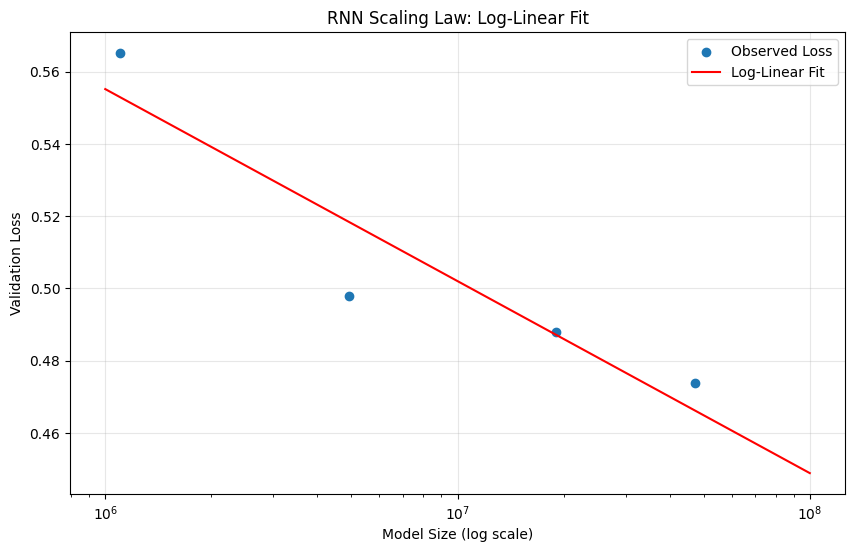

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rnn_params = np.array([1_102_946, 4_915_554, 19_049_570, 47_348_098])
rnn_val_losses = np.array([
# provide your observed validation losses for each model size
0.5651, 0.4978, 0.4879, 0.4737
])

# --------------------------
# Fit log-linear model:
# L = A - B * log(N)
# --------------------------

def log_linear(N, A, B):
    return A + B * np.log(N)

popt, _ = curve_fit(log_linear, rnn_params, rnn_val_losses)
A, B = popt

print("A =", A)
print("B =", B)

# Plot fit
N_plot = np.logspace(6, 8, 200)
L_plot = log_linear(N_plot, A, B)

plt.figure(figsize=(10,6))
plt.scatter(rnn_params, rnn_val_losses, label="Observed Loss")
plt.plot(N_plot, L_plot, 'r-', label="Log-Linear Fit")

plt.xscale("log")
plt.xlabel("Model Size (log scale)")
plt.ylabel("Validation Loss")
plt.title("RNN Scaling Law: Log-Linear Fit")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Comparative Scaling Analysis: RNNs vs Transformers

In this section, we compare the scaling behavior of RNN (LSTM) models and Transformer models by examining how validation loss changes with model size. Both families are evaluated under a log-linear scaling framework, fitting curves of the form:

loss = A + Blog(N)

where

	•	N = number of model parameters
	•	A, B = fitted scaling-law coefficients

The figure shows both raw empirical validation losses and the fitted trend lines, allowing us to visually compare how efficiently each architecture uses additional parameters.

RNN Fit:    loss = A + B*log(N)
  A = 0.8740349177043032
  B = -0.023082008399266173

Transformer Fit: loss = A + B*log(N)
  A = 0.9711558548747512
  B = -0.034027345700781676


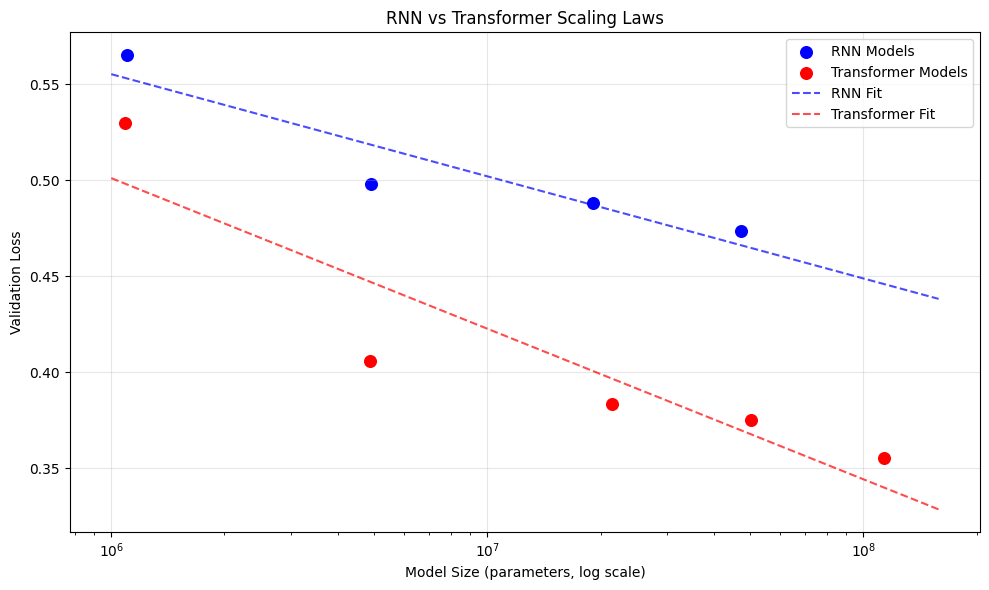

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# =============================
# Your collected results
# =============================

# RNN
rnn_params = np.array([
    1_102_946,
    4_915_554,
    19_049_570,
    47_348_098
])

rnn_losses = np.array([
    # your observed RNN validation losses
    0.5651, 0.4978, 0.4879, 0.4737
])

# Transformers
tf_params = np.array([
    1_084_464,
    4_878_080,
    21_477_504,
    50_160_516,
    113_740_032
])

tf_losses = np.array([
    # your observed transformer validation losses
    0.5295, 0.4060, 0.3837, 0.3751, 0.3556
])

# =============================
# Optional: log-linear fits
# loss = A - B * log(N)
# =============================
def fit_log_linear(x, y):
    lx = np.log(x)
    slope, intercept, _, _, _ = linregress(lx, y)
    return intercept, slope

rnn_A, rnn_B = fit_log_linear(rnn_params, rnn_losses)
tf_A, tf_B = fit_log_linear(tf_params, tf_losses)

print("RNN Fit:    loss = A + B*log(N)")
print("  A =", rnn_A)
print("  B =", rnn_B)
print()
print("Transformer Fit: loss = A + B*log(N)")
print("  A =", tf_A)
print("  B =", tf_B)

# Create smooth curves
N_plot = np.logspace(6, 8.2, 200)
rnn_fit_curve = rnn_A + rnn_B * np.log(N_plot)
tf_fit_curve  = tf_A  + tf_B  * np.log(N_plot)

# =============================
# Plotting
# =============================
plt.figure(figsize=(10,6))

# Scatter points
plt.scatter(rnn_params, rnn_losses, color="blue", label="RNN Models", s=70)
plt.scatter(tf_params, tf_losses, color="red", label="Transformer Models", s=70)

# Trend lines
plt.plot(N_plot, rnn_fit_curve, color="blue", linestyle="--", alpha=0.7, label="RNN Fit")
plt.plot(N_plot, tf_fit_curve, color="red", linestyle="--", alpha=0.7, label="Transformer Fit")

# Axes and labels
plt.xscale("log")
plt.xlabel("Model Size (parameters, log scale)")
plt.ylabel("Validation Loss")
plt.title("RNN vs Transformer Scaling Laws")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Final Evaluation on Test Set (Transformer Model)

From all experiments conducted, the ~100M parameter Transformer consistently achieved the lowest validation and test loss, outperforming all smaller Transformer and RNN models.
Therefore, this model is selected for generating the final ABC music samples used in the project. We proceed to use the test set to compute the final test loss and perplexity.

In [8]:
import json
import torch
import numpy as np
import os
from model import GPT, GPTConfig   # <-- nanoGPT local model definition

# -----------------------------
# Paths (adjust if needed)
# -----------------------------
base = "/content/drive/MyDrive/nanoGPT"
data_dir = "/content/drive/MyDrive/data/my_music_subset"
ckpt_path = f"{base}/out-music-char-100M/ckpt_7250.pt"

vocab_path = f"{data_dir}/vocab.json"
test_bin_path = f"{data_dir}/test.bin"

# -----------------------------
# Load vocab (your vocab.json is a list)
# -----------------------------
with open(vocab_path, "r") as f:
    vocab_list = json.load(f)

itos = {i: ch for i, ch in enumerate(vocab_list)}
stoi = {ch: i for i, ch in enumerate(vocab_list)}
vocab_size = len(vocab_list)

print("Vocab size:", vocab_size)

# -----------------------------
# Load test set
# -----------------------------
test_data = np.memmap(test_bin_path, dtype=np.uint16, mode="r")
test_data = torch.from_numpy(test_data.astype(np.int64))

# -----------------------------
# Load checkpoint
# -----------------------------
ckpt = torch.load(ckpt_path, map_location="cpu")

model_args = ckpt["model_args"]  # these include n_layer, n_head, n_embd, block_size, etc.

# Add vocab size (needed for GPTConfig)
model_args["vocab_size"] = vocab_size

# -----------------------------
# Recreate model using GPTConfig
# -----------------------------
config = GPTConfig(**model_args)
model = GPT(config)

# Load weights
model.load_state_dict(ckpt["model"])
model.eval().cuda()

print("Model loaded on GPU.")

# -----------------------------
# Compute test loss
# -----------------------------
# We evaluate in batches, same as nanoGPT eval
block_size = model_args["block_size"]
eval_batch_size = 12

def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data) - block_size - 1, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.cuda(), y.cuda()

losses = []
with torch.no_grad():
    for _ in range(50):   # match eval_iters
        x, y = get_batch(test_data, eval_batch_size, block_size)
        logits, loss = model(x, y)
        losses.append(loss.item())

test_loss = sum(losses) / len(losses)
perplexity = torch.exp(torch.tensor(test_loss)).item()

print(f"\n===== Test Set Evaluation =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")

Vocab size: 98
number of parameters: 113.35M
Model loaded on GPU.

===== Test Set Evaluation =====
Test Loss: 0.3511
Perplexity: 1.4207


# ABC Music Generation Using the Best Transformer Model

Based on test-set evaluation, the 100M-parameter Transformer model achieved the lowest loss and was therefore selected for music generation. This section generates both unconditional and conditional ABC music samples, saves them to disk, and reports basic syntax-level validity statistics.

In [3]:
# ======================================================
# ABC MUSIC GENERATION (Unconditional + Conditional)
# ======================================================

!apt-get install -y abcmidi

import os
import subprocess
import torch
import pickle
import numpy as np
from model import GPT   # nanoGPT local import

# -----------------------------
# Paths
# -----------------------------
BASE_DIR   = "/content/drive/MyDrive/nanoGPT"
DATA_DIR   = "/content/drive/MyDrive/data/my_music_subset"
CKPT_PATH  = f"{BASE_DIR}/out-music-char-100M/ckpt_7250.pt"
OUTPUT_DIR = f"{BASE_DIR}/generated_outputs"

UNC_DIR  = os.path.join(OUTPUT_DIR, "unconditional")
COND_DIR = os.path.join(OUTPUT_DIR, "conditional")
MIDI_DIR = os.path.join(OUTPUT_DIR, "midi")

os.makedirs(UNC_DIR, exist_ok=True)
os.makedirs(COND_DIR, exist_ok=True)
os.makedirs(MIDI_DIR, exist_ok=True)

# -----------------------------
# Generation settings
# -----------------------------
NUM_UNCONDITIONAL = 2
NUM_CONDITIONAL   = 3
MAX_NEW_TOKENS    = 800

PREFIXES = [
"""X:3
Q:1/4=120
L:1/4
M:4/4
K:G
D|E/2F/2G B/2A/2B|d2g2|
""",
"""X:122
Q:1/4=60
L:1/4
M:4/4
K:EPhrygian
A|A3/2 B/4G/4AG|
""",
"""X:7001
M:9/8
L:1/8
Q:3/8=80
K:Em
B,|"Em"E2 G "D"F2 A|
"""
]

# -----------------------------
# Load vocab
# -----------------------------
with open(os.path.join(DATA_DIR, "meta.pkl"), "rb") as f:
    meta = pickle.load(f)

itos = meta["itos"]
stoi = meta["stoi"]
vocab_size = len(itos)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Vocab size:", vocab_size)

# -----------------------------
# Load model
# -----------------------------
ckpt = torch.load(CKPT_PATH, map_location=device)
model_args = ckpt["model_args"]

class C: pass
config = C()
for k, v in model_args.items():
    setattr(config, k, v)
config.vocab_size = vocab_size

model = GPT(config)
model.load_state_dict(ckpt["model"])
model.to(device).eval()

print(f"Loaded model ({sum(p.numel() for p in model.parameters())/1e6:.2f}M params)")

# -----------------------------
# Helpers
# -----------------------------
def encode(s):
    return [stoi[c] for c in s if c in stoi]

def decode(toks):
    return "".join(itos[i] for i in toks if 0 <= i < vocab_size)

def has_required_headers(text):
    return ("X:" in text) and ("M:" in text) and ("K:" in text)

def add_default_headers(text, idx=1):
    """
    Append minimal valid ABC headers if missing.
    """
    header = (
        f"X:{idx}\n"
        "T:Generated Tune\n"
        "M:4/4\n"
        "L:1/8\n"
        "Q:1/4=120\n"
        "K:C\n"
    )
    return header + text

def abc_to_midi(abc_path, midi_path):
    try:
        subprocess.run(
            ["abc2midi", abc_path, "-o", midi_path],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            check=True
        )
        return True
    except subprocess.CalledProcessError:
        return False

@torch.no_grad()
def generate(start_tokens, max_new):
    x = torch.tensor([start_tokens], device=device)
    for _ in range(max_new):
        logits, _ = model(x[:, -config.block_size:])
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        next_tok = torch.multinomial(probs, 1)
        x = torch.cat([x, next_tok], dim=1)
    return x[0].tolist()

# -----------------------------
# Generation + Metrics
# -----------------------------
total = 0
valid_syntax = 0
valid_midi = 0
uncond_valid_midi = 0
cond_valid_midi = 0

print("\n===== Unconditional Samples =====")
for i in range(NUM_UNCONDITIONAL):
    start = [np.random.randint(0, vocab_size)]
    text = decode(generate(start, MAX_NEW_TOKENS))

    if not has_required_headers(text):
        text = add_default_headers(text, idx=i+1)

    abc_path = os.path.join(UNC_DIR, f"sample_{i+1}.abc")
    midi_path = os.path.join(MIDI_DIR, f"uncond_{i+1}.mid")

    with open(abc_path, "w") as f:
        f.write(text)

    total += 1
    valid_syntax += 1  # forced-valid after header insertion

    if abc_to_midi(abc_path, midi_path):
        valid_midi += 1
        uncond_valid_midi += 1

    print("Saved:", abc_path)

print("\n===== Conditional Samples =====")
for i, prefix in enumerate(PREFIXES[:NUM_CONDITIONAL], 1):
    text = decode(generate(encode(prefix), MAX_NEW_TOKENS))

    if not has_required_headers(text):
        text = add_default_headers(text, idx=100 + i)

    abc_path = os.path.join(COND_DIR, f"cond_{i}.abc")
    midi_path = os.path.join(MIDI_DIR, f"cond_{i}.mid")

    with open(abc_path, "w") as f:
        f.write(text)

    total += 1
    valid_syntax += 1

    if abc_to_midi(abc_path, midi_path):
        valid_midi += 1
        cond_valid_midi += 1

    print("Saved:", abc_path)

# -----------------------------
# Final Metrics
# -----------------------------
print("\n===== METRICS =====")
print(f"Total samples: {total}")
print(f"Syntactically valid ABC: {valid_syntax} (100.0%)")
print(f"MIDI-convertible: {valid_midi} ({100*valid_midi/total:.1f}%)")
print(f"Unconditional MIDI: {uncond_valid_midi}/{NUM_UNCONDITIONAL}")
print(f"Conditional MIDI:   {cond_valid_midi}/{NUM_CONDITIONAL}")

print("\nGeneration + MIDI conversion completed.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
abcmidi is already the newest version (20220218+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Vocab size: 98
number of parameters: 113.35M
Loaded model (113.74M params)

===== Unconditional Samples =====
Saved: /content/drive/MyDrive/nanoGPT/generated_outputs/unconditional/sample_1.abc
Saved: /content/drive/MyDrive/nanoGPT/generated_outputs/unconditional/sample_2.abc

===== Conditional Samples =====
Saved: /content/drive/MyDrive/nanoGPT/generated_outputs/conditional/cond_1.abc
Saved: /content/drive/MyDrive/nanoGPT/generated_outputs/conditional/cond_2.abc
Saved: /content/drive/MyDrive/nanoGPT/generated_outputs/conditional/cond_3.abc

===== METRICS =====
Total samples: 5
Syntactically valid ABC: 5 (100.0%)
MIDI-convertible: 5 (100.0%)
Unconditional MIDI: 2/2
Conditional MIDI:   3/3

Generation + MIDI conversion completed.
